### Using Vision Transformer to classify images

#### Import libraries and set device

In [1]:
import torch
import torch.nn as nn
import tqdm
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

c:\Users\NSharma\anaconda3\envs\img_retrieval\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# =========================
# 2. Imports & Config
# =========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
NUM_CLASSES = 10  # adjust to your dataset


#### Import libraries for handling image data

In [5]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#### Load Deit-Tiny pretrained on ImageNet

In [3]:
# Load DeiT-Tiny pretrained on Imagenet
model = timm.create_model('deit_tiny_patch16_224',pretrained=True)

# Replace classification head for 10 classes
model.head = nn.Linear(model.head.in_features,10)

# move model to GPU
model= model.to(device)

#### Define Image Transforms

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # upscale to match DeiT input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, split='train', transform=None,root_dir='.'):
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df['split'] == split]
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.df['class_label'].unique()))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir,row['image_path'])
        image = Image.open(img_path).convert('RGB')
        label = self.label_map[row['class_label']]

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
train_dataset = CustomImageDataset(csv_file='D:\multi-class-image-classifier\labels.csv', split='train', transform=transform,root_dir='D:\multi-class-image-classifier')
val_dataset = CustomImageDataset(csv_file='D:\multi-class-image-classifier\labels.csv', split='val', transform=transform,root_dir='D:\multi-class-image-classifier')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [9]:
# =========================
# 4. Model Definition
# =========================
def get_model(model_name="deit_tiny_patch16_224", num_classes=NUM_CLASSES):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(DEVICE)

model = get_model("deit_tiny_patch16_224")


In [10]:
# =========================
# 5. Training & Evaluation
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

def train_one_epoch(model, loader):
    model.train()
    total_loss, preds, labels = 0, [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds.extend(out.argmax(1).cpu().numpy())
        labels.extend(y.cpu().numpy())
    return total_loss/len(loader), accuracy_score(labels, preds), f1_score(labels, preds, average="macro")

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())
    return accuracy_score(labels, preds), f1_score(labels, preds, average="macro")


In [11]:
# =========================
# 6. Run Training
# =========================
for epoch in range(EPOCHS):
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader)
    val_acc, val_f1 = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}, Val F1={val_f1:.3f}")


Epoch 1: Loss=1.6382, Train Acc=0.491, Val Acc=0.699, Val F1=0.685
Epoch 2: Loss=0.4816, Train Acc=0.960, Val Acc=0.764, Val F1=0.764
Epoch 3: Loss=0.1474, Train Acc=0.996, Val Acc=0.756, Val F1=0.753
Epoch 4: Loss=0.0584, Train Acc=1.000, Val Acc=0.764, Val F1=0.765
Epoch 5: Loss=0.0318, Train Acc=1.000, Val Acc=0.789, Val F1=0.785
Epoch 6: Loss=0.0219, Train Acc=1.000, Val Acc=0.772, Val F1=0.772
Epoch 7: Loss=0.0170, Train Acc=1.000, Val Acc=0.805, Val F1=0.803
Epoch 8: Loss=0.0140, Train Acc=1.000, Val Acc=0.780, Val F1=0.781
Epoch 9: Loss=0.0119, Train Acc=1.000, Val Acc=0.789, Val F1=0.788
Epoch 10: Loss=0.0104, Train Acc=1.000, Val Acc=0.789, Val F1=0.788


In [ ]:
# =========================
# 7. Attribute Prediction (Multi-label Extension)
# =========================
# Replace criterion with BCEWithLogitsLoss and adjust dataset labels accordingly.
# Example skeleton:

multi_label_model = get_model("mobilevit_s", num_classes=10)  # e.g., 20 attributes
criterion_multi = nn.BCEWithLogitsLoss()


#### Checking if DataLoader dataset matches with our label.csv file

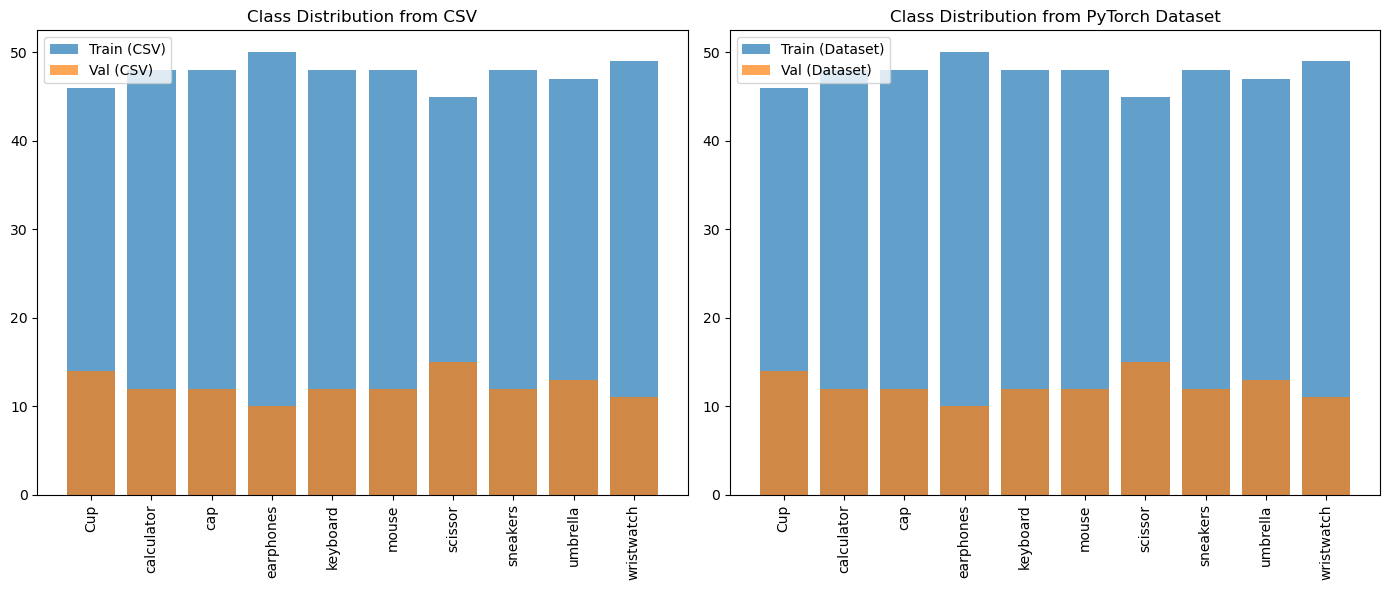

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load CSV
df = pd.read_csv('D:\multi-class-image-classifier\labels.csv')

# CSV-based class counts
csv_train_counts = df[df['split'] == 'train']['class_label'].value_counts()
csv_val_counts = df[df['split'] == 'val']['class_label'].value_counts()

# Dataset-based class counts
train_labels = [label for _, label in train_dataset]
val_labels = [label for _, label in val_dataset]

train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)

# Convert to sorted lists
csv_classes = sorted(set(df['class_label']))
train_counts_csv = [csv_train_counts.get(cls, 0) for cls in csv_classes]
val_counts_csv = [csv_val_counts.get(cls, 0) for cls in csv_classes]
train_counts_ds = [train_label_counts.get(i, 0) for i in range(len(csv_classes))]
val_counts_ds = [val_label_counts.get(i, 0) for i in range(len(csv_classes))]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].bar(csv_classes, train_counts_csv, label='Train (CSV)', alpha=0.7)
axs[0].bar(csv_classes, val_counts_csv, label='Val (CSV)', alpha=0.7)
axs[0].set_title('Class Distribution from CSV')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=90)

axs[1].bar(csv_classes, train_counts_ds, label='Train (Dataset)', alpha=0.7)
axs[1].bar(csv_classes, val_counts_ds, label='Val (Dataset)', alpha=0.7)
axs[1].set_title('Class Distribution from PyTorch Dataset')
axs[1].legend()
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


### Training loop setup for DeiT-Tiny

#### Define loss and optimizer

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Classification loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


#### Training and Validation Loops

In [9]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(loader), acc, f1

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(loader), acc, f1



#### Training loop

In [10]:
num_epochs = 20
best_val_f1 = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_deit_tiny.pth')


100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


Epoch 1/20
Train Loss: 1.1764 | Acc: 0.5954 | F1: 0.5941
Val   Loss: 0.8982 | Acc: 0.7480 | F1: 0.7565


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


Epoch 2/20
Train Loss: 0.1876 | Acc: 0.9581 | F1: 0.9579
Val   Loss: 1.0882 | Acc: 0.6748 | F1: 0.6645


100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


Epoch 3/20
Train Loss: 0.0983 | Acc: 0.9811 | F1: 0.9810
Val   Loss: 0.9421 | Acc: 0.7561 | F1: 0.7622


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


Epoch 4/20
Train Loss: 0.0350 | Acc: 0.9916 | F1: 0.9916
Val   Loss: 0.6836 | Acc: 0.7886 | F1: 0.7887


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


Epoch 5/20
Train Loss: 0.0176 | Acc: 0.9979 | F1: 0.9979
Val   Loss: 0.7019 | Acc: 0.7805 | F1: 0.7834


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


Epoch 6/20
Train Loss: 0.0118 | Acc: 0.9958 | F1: 0.9958
Val   Loss: 0.6878 | Acc: 0.8374 | F1: 0.8412


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 7/20
Train Loss: 0.0179 | Acc: 0.9958 | F1: 0.9958
Val   Loss: 1.1370 | Acc: 0.7642 | F1: 0.7525


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch 8/20
Train Loss: 0.0152 | Acc: 0.9937 | F1: 0.9937
Val   Loss: 0.8984 | Acc: 0.7398 | F1: 0.7475


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


Epoch 9/20
Train Loss: 0.0115 | Acc: 0.9958 | F1: 0.9958
Val   Loss: 0.9402 | Acc: 0.7317 | F1: 0.7244


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 10/20
Train Loss: 0.0460 | Acc: 0.9895 | F1: 0.9895
Val   Loss: 0.8903 | Acc: 0.7967 | F1: 0.7989


100%|██████████| 15/15 [00:04<00:00,  3.74it/s]


Epoch 11/20
Train Loss: 0.0417 | Acc: 0.9895 | F1: 0.9895
Val   Loss: 1.1154 | Acc: 0.7154 | F1: 0.7213


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 12/20
Train Loss: 0.0140 | Acc: 0.9958 | F1: 0.9958
Val   Loss: 1.0363 | Acc: 0.7236 | F1: 0.7261


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch 13/20
Train Loss: 0.0157 | Acc: 0.9979 | F1: 0.9979
Val   Loss: 0.8949 | Acc: 0.7561 | F1: 0.7541


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 14/20
Train Loss: 0.0026 | Acc: 1.0000 | F1: 1.0000
Val   Loss: 0.7904 | Acc: 0.7724 | F1: 0.7738


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Epoch 15/20
Train Loss: 0.0013 | Acc: 1.0000 | F1: 1.0000
Val   Loss: 0.7586 | Acc: 0.7805 | F1: 0.7824


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 16/20
Train Loss: 0.0010 | Acc: 1.0000 | F1: 1.0000
Val   Loss: 0.7492 | Acc: 0.7886 | F1: 0.7908


100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch 17/20
Train Loss: 0.0009 | Acc: 1.0000 | F1: 1.0000
Val   Loss: 0.7462 | Acc: 0.7886 | F1: 0.7908


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 18/20
Train Loss: 0.0008 | Acc: 1.0000 | F1: 1.0000
Val   Loss: 0.7449 | Acc: 0.7967 | F1: 0.7984


100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch 19/20
Train Loss: 0.0007 | Acc: 1.0000 | F1: 1.0000
Val   Loss: 0.7427 | Acc: 0.7967 | F1: 0.7984


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


Epoch 20/20
Train Loss: 0.0007 | Acc: 1.0000 | F1: 1.0000
Val   Loss: 0.7409 | Acc: 0.7967 | F1: 0.7984


In [1]:
from safetensors.torch import load_file
import timm
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
state_dict = load_file("best_deit_tiny.safetensors")
model = timm.create_model("deit_tiny_patch16_224", pretrained=False)
model.head = nn.Linear(model.head.in_features, state_dict["head.weight"].shape[0])
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()


c:\Users\NSharma\anaconda3\envs\torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


In [2]:
print(torch.__version__) 

2.5.1


In [ ]:
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a lightweight model
text_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

@torch.no_grad()
def encode_text(text):
    emb = text_model.encode(text, convert_to_tensor=True, device=device)
    return F.normalize(emb, dim=0).cpu()



c:\Users\NSharma\anaconda3\envs\torch_gpu\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\NSharma\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
